In [119]:
import tensorflow as tf
import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
import time
import cv2
import os
import requests
import IPython.display as display
import PIL.Image

from cv2 import cvtColor
from cv2 import imread
from cv2 import COLOR_BGR2RGB

from keras import Model
from keras.preprocessing.image import load_img, img_to_array
from os import listdir

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten

In [3]:
# ==== Constante ==== #
IMAGE_WEIGHT = 224
IMAGE_HEIGHT = 224
IMAGE_COLOR = 3
IMAGE_SHAPE = [IMAGE_WEIGHT, IMAGE_HEIGHT, IMAGE_COLOR]

In [120]:
def load_image(path):

    img = load_img(path, target_size=(224, 224))
    # img = cvtColor(img, COLOR_BGR2RGB)
    img = img_to_array(img)
    img = img / 255.

    return (img)

In [121]:
def create_batch_image(img):

    img = tf.expand_dims(img ,axis=0)
    return (img)

In [126]:
def open_all_img_directory(directory) :

  list_of_files = list()

  for filename in listdir(directory):

      path = directory + '/' + filename
      
      img = load_image(path)
      print('loaded %s' % filename)
      # img = create_batch_image(img)
      list_of_files.append(img)

  array = np.array(list_of_files)
  return (array)


In [131]:
def open_dataset(dir_1 : str, dir_2 : str):

    data_1 = open_all_img_directory(dir_1)
    data_2 = open_all_img_directory(dir_2)

    return (data_1, data_2)


In [132]:
disease_images, healthy_images = open_dataset('leaves_img/malade', 'leaves_img/sain')

loaded img14.jpg
loaded images (1).jpg
loaded powdery-mildew-on-tomato-260nw-1023874654.jpg
loaded powdery-mildew-tomato-260nw-596614925.jpg
loaded fungal-plant-disease-powdery-mildew-260nw-1910461837.jpg
loaded powdery-mildew-tomato-260nw-596614892.jpg
loaded istockphoto-1165563987-612x612.jpg
loaded powdery-mildew-on-tomato-260nw-1324604306.jpg
loaded imagefeuillemalade8.jpg
loaded istockphoto-1276445035-612x612.jpg
loaded imagefeuillemalade10.jpg
loaded istockphoto-925597534-612x612.jpg
loaded téléchargement (11).jpg
loaded téléchargement (16).jpg
loaded img8.jpg
loaded téléchargement (17).jpg
loaded téléchargement (12).jpg
loaded téléchargement (2).jpg
loaded téléchargement (1).jpg
loaded téléchargement (14).jpg
loaded img17.jpg
loaded img5.jpg
loaded plant-disease-powdery-mildew-on-260nw-2218362155.jpg
loaded téléchargement (15).jpg
loaded imagefeuillemalade1.jpg
loaded img13.jpg
loaded tomato-disease-powdery-mildew-causal-260nw-1718646130.jpg
loaded powdery-mildew-tomato-260nw-10

In [135]:
print(disease_images.shape, healthy_images.shape)

(61, 224, 224, 3) (96, 224, 224, 3)


In [101]:
healthy_images

[array([[[0.5254902 , 0.52156863, 0.6       ],
         [0.43921569, 0.43529412, 0.51372549],
         [0.44705882, 0.43921569, 0.51372549],
         ...,
         [0.32156863, 0.54509804, 0.36862745],
         [0.42745098, 0.6       , 0.39215686],
         [0.54117647, 0.69411765, 0.4745098 ]],
 
        [[0.44705882, 0.44313725, 0.52156863],
         [0.44313725, 0.43921569, 0.51764706],
         [0.45490196, 0.45098039, 0.52941176],
         ...,
         [0.29803922, 0.52941176, 0.35294118],
         [0.2745098 , 0.4627451 , 0.25882353],
         [0.45098039, 0.61960784, 0.39607843]],
 
        [[0.48627451, 0.49019608, 0.57254902],
         [0.43921569, 0.44313725, 0.52156863],
         [0.36078431, 0.36470588, 0.44313725],
         ...,
         [0.38039216, 0.62745098, 0.45490196],
         [0.29803922, 0.50588235, 0.30980392],
         [0.4627451 , 0.65490196, 0.43529412]],
 
        ...,
 
        [[0.64313725, 0.75294118, 0.81960784],
         [0.6       , 0.69411765, 0.80392

In [110]:
test = np.stack(healthy_images)
test.shape

ValueError: all input arrays must have the same shape

(-0.5, 267.5, 187.5, -0.5)

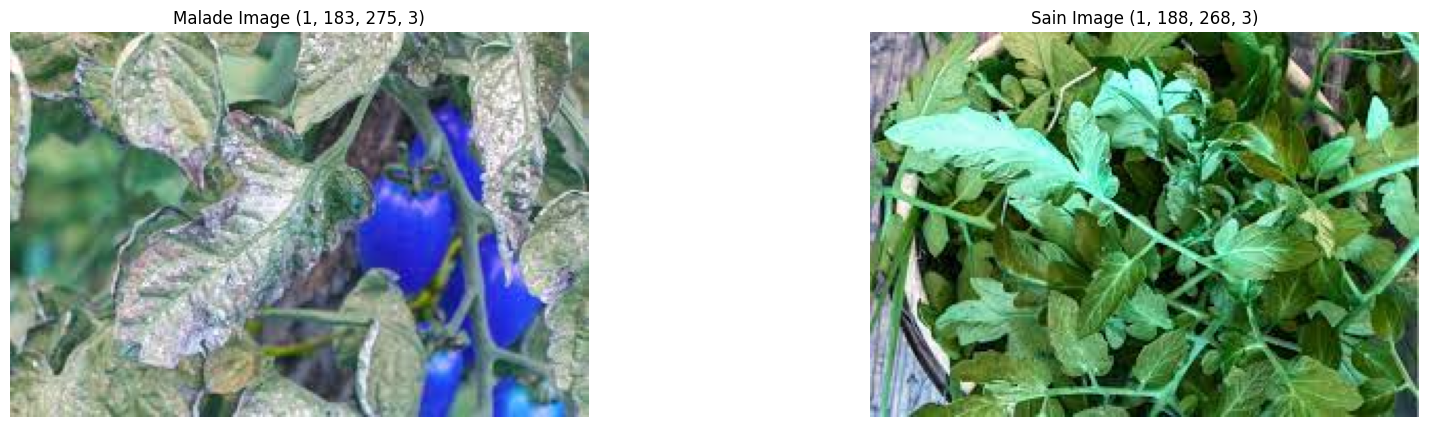

In [69]:
malade = disease_images[0]
sain = healthy_images[0]

# image = np.reshape(malade, (malade.shape[3], malade.shape[1], malade.shape[2]))
# plt.imshow(image)
# # print(malade)
#
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

ax[0].imshow(malade[0])
ax[0].title.set_text(f'Malade Image {malade.shape}')
ax[0].axis('off')

ax[1].imshow(sain[0])
ax[1].title.set_text(f'Sain Image {sain.shape}')
ax[1].axis('off')

In [ ]:
def Create_transfert_learning_Model(dim_prediction):
  
    vgg = tf.keras.applications.VGG19(include_top=False, 
                                      input_shape=IMAGE_SHAPE,
                                      weights='imagenet')
    for layer in vgg.layers:
      layer.trainable = False

    last_conv_layer = vgg.output

    flatten_layer = Flatten(name='flatten_layer')(last_conv_layer)
    fully_connected = Dense(4096, name='fully_connected')(flatten_layer) 
    prediction = Dense(dim_prediction, activation='softmax', name='lamioude')(fully_connected)


    model = Model(inputs=vgg.input, outputs=prediction)
    return model



In [ ]:
model = Create_transfert_learning_Model(3)
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   